<a href="https://colab.research.google.com/github/silo86/flower_classifier/blob/main/flower_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 9s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


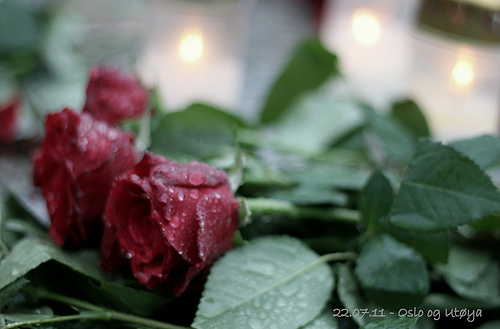

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

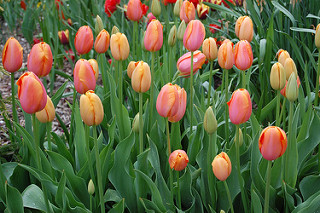

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


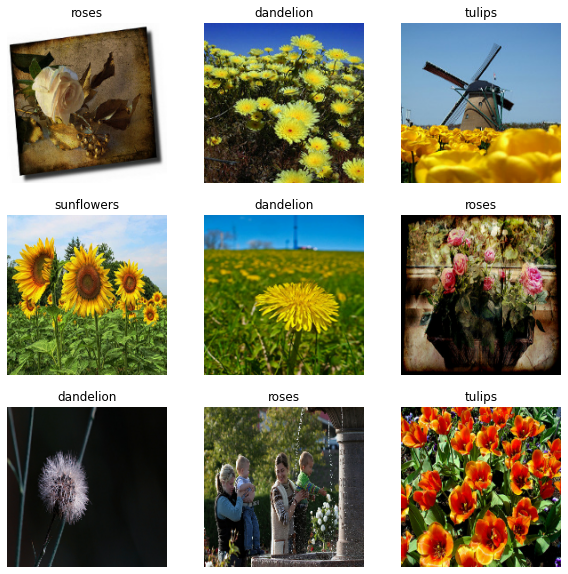

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99930793


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 16s 65ms/step - loss: 1.3744 - accuracy: 0.4247 - val_loss: 1.1723 - val_accuracy: 0.5163
Epoch 2/10
92/92 [==============================] - 4s 48ms/step - loss: 0.9843 - accuracy: 0.6213 - val_loss: 0.9343 - val_accuracy: 0.6158
Epoch 3/10
92/92 [==============================] - 4s 46ms/step - loss: 0.7816 - accuracy: 0.6996 - val_loss: 0.8990 - val_accuracy: 0.6608
Epoch 4/10
92/92 [==============================] - 4s 47ms/step - loss: 0.5491 - accuracy: 0.7994 - val_loss: 0.8943 - val_accuracy: 0.6744
Epoch 5/10
92/92 [==============================] - 4s 47ms/step - loss: 0.3147 - accuracy: 0.8903 - val_loss: 1.1544 - val_accuracy: 0.6662
Epoch 6/10
92/92 [==============================] - 4s 47ms/step - loss: 0.1615 - accuracy: 0.9472 - val_loss: 1.3934 - val_accuracy: 0.6294
Epoch 7/10
92/92 [==============================] - 4s 47ms/step - loss: 0.0919 - accuracy: 0.9745 - val_loss: 1.6501 - val_accuracy: 0.6362
Epoch 8/10
9

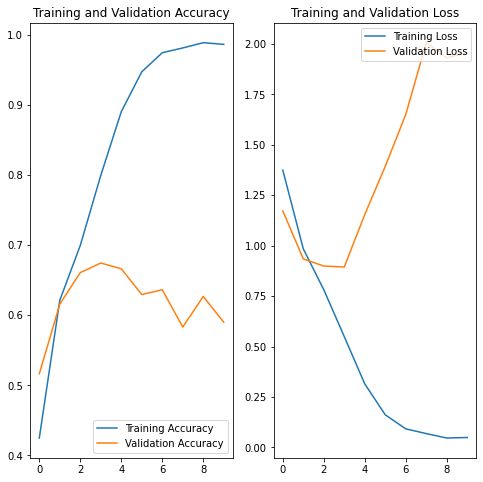

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

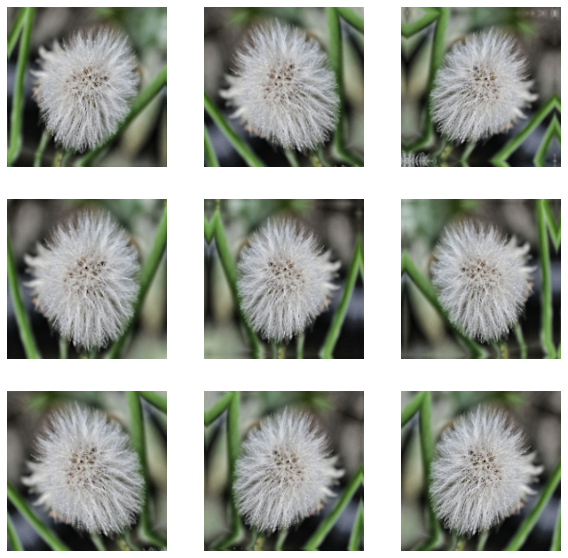

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 56ms/step - loss: 1.4628 - accuracy: 0.3566 - val_loss: 1.1738 - val_accuracy: 0.5218
Epoch 2/15
92/92 [==============================] - 5s 53ms/step - loss: 1.0759 - accuracy: 0.5688 - val_loss: 0.9736 - val_accuracy: 0.6185
Epoch 3/15
92/92 [==============================] - 5s 52ms/step - loss: 0.9565 - accuracy: 0.6236 - val_loss: 1.0226 - val_accuracy: 0.5858
Epoch 4/15
92/92 [==============================] - 5s 52ms/step - loss: 0.8945 - accuracy: 0.6550 - val_loss: 0.9920 - val_accuracy: 0.5926
Epoch 5/15
92/92 [==============================] - 5s 52ms/step - loss: 0.8308 - accuracy: 0.6873 - val_loss: 0.8130 - val_accuracy: 0.6839
Epoch 6/15
92/92 [==============================] - 5s 52ms/step - loss: 0.7943 - accuracy: 0.6969 - val_loss: 0.8023 - val_accuracy: 0.6771
Epoch 7/15
92/92 [==============================] - 5s 53ms/step - loss: 0.7431 - accuracy: 0.7119 - val_loss: 0.8584 - val_accuracy: 0.6649
Epoch 8/15
92

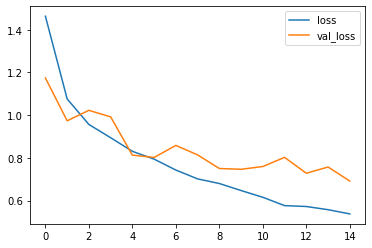

In [ ]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'])

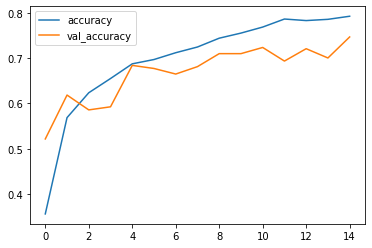

In [ ]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('flowers_model_from_colab.h5',save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_accuracy',restore_best_weights=True)

In [ ]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,early_stopping]
)

Epoch 1/500
92/92 [==============================] - 5s 53ms/step - loss: 0.3377 - accuracy: 0.8777 - val_loss: 0.7370 - val_accuracy: 0.7711
Epoch 2/500
92/92 [==============================] - 5s 52ms/step - loss: 0.3503 - accuracy: 0.8696 - val_loss: 0.7248 - val_accuracy: 0.7589
Epoch 3/500
92/92 [==============================] - 5s 53ms/step - loss: 0.3134 - accuracy: 0.8791 - val_loss: 0.7118 - val_accuracy: 0.7807
Epoch 4/500
92/92 [==============================] - 5s 53ms/step - loss: 0.3065 - accuracy: 0.8839 - val_loss: 0.7753 - val_accuracy: 0.7670
Epoch 5/500
92/92 [==============================] - 5s 52ms/step - loss: 0.3068 - accuracy: 0.8896 - val_loss: 0.8127 - val_accuracy: 0.7520
Epoch 6/500
92/92 [==============================] - 5s 52ms/step - loss: 0.3193 - accuracy: 0.8699 - val_loss: 0.6734 - val_accuracy: 0.7807
Epoch 7/500
92/92 [==============================] - 5s 53ms/step - loss: 0.3036 - accuracy: 0.8794 - val_loss: 0.7113 - val_accuracy: 0.7861
Epoch 

In [ ]:
model.evaluate(val_ds)

23/23 [==============================] - 1s 22ms/step - loss: 0.7492 - accuracy: 0.7956


[0.7491642236709595, 0.7956403493881226]

In [ ]:
model.save('flowers_model_from_colab.h5')

In [ ]:
from google.colab import files
files.download('flowers_model_from_colab.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#modelo = keras.models.load_model('flowers_model.h5')